# Low-Thrust Transfer: Earth → Mars (numerical, continuous acceleration)

This notebook models a **low-thrust (continuous acceleration)** trajectory between circular, coplanar heliocentric orbits (Earth → Mars), representing an **electric propulsion system** such as an ion engine.

Unlike impulsive transfers, the spacecraft experiences a **constant small thrust** over long durations, producing a spiral orbit that gradually increases its semi-major axis.

The notebook performs:

- **Numerical integration** of motion under constant tangential acceleration,
- **Tracking of radial distance** as the spacecraft spirals outward,
- **Estimation of total Δv** via integrated acceleration,
- **Comparison of transfer time and efficiency** relative to impulsive methods,
- **Approximate propellant mass estimation** using a high exhaust-velocity model.

Results are saved to `results/lowthrust_summary.csv`.


LOW-THRUST SIMULATION (constant thrust, tangential steering)
Integration method used: DOP853
Thrust acceleration (m/s^2): 2.000e-04
Propagation time (days): 300
Total Δv (analytic a*dt): 5.184000 km/s
Total Δv (integrated thrust vector): 5.184000 km/s
Estimated propellant for Isp=3000.0 s and wet mass 1000.0 kg: 161.556 kg
Saved trajectory CSV to results\low_thrust_trajectory.csv


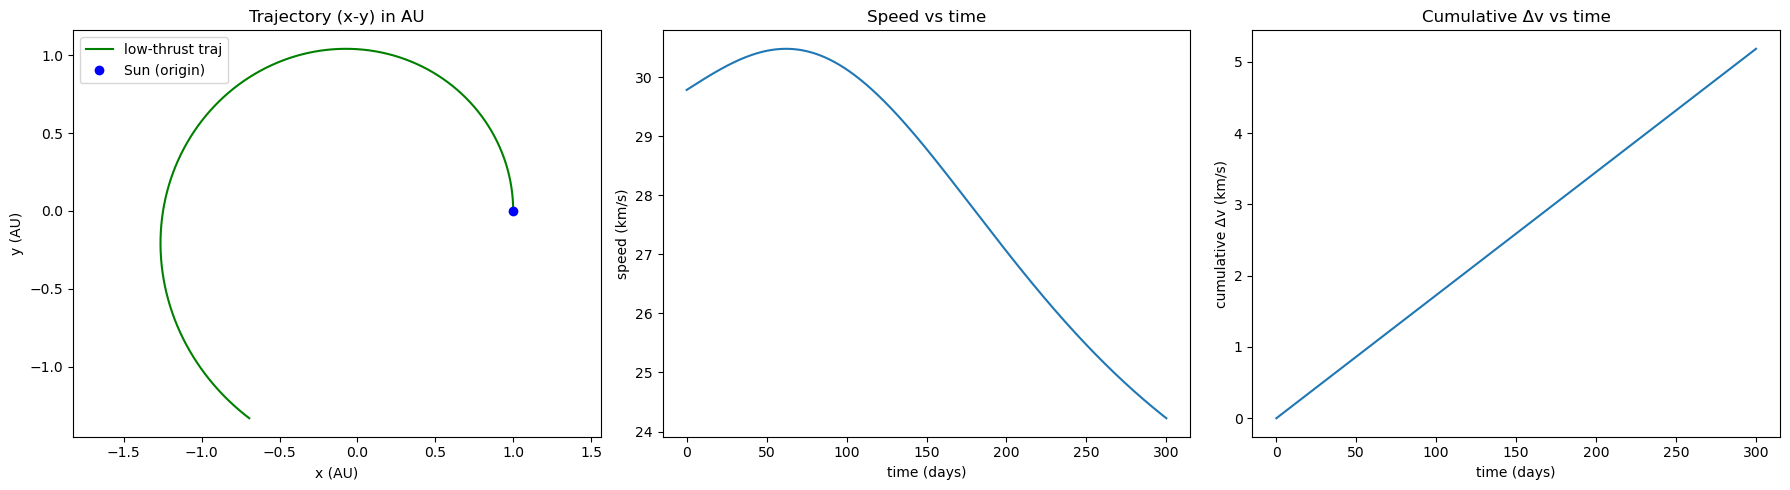

In [1]:
# Low-thrust Earth->Mars simulation (robust, scipy-based)
# Copy-paste into one notebook cell and run.
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math
import os

# --- optional: use astropy quantities for clarity (not required) ---
try:
    from astropy import units as u
    use_astropy = True
except Exception:
    use_astropy = False

# -----------------------------
# PARAMETERS (edit these)
# -----------------------------
# Physical constants and units
if use_astropy:
    mu = (1.32712440018e11 * u.km**3 / u.s**2).to(u.m**3 / u.s**2).value  # Sun mu in m^3/s^2
    AU_m = (1.0 * u.AU).to(u.m).value
    km = 1000.0
else:
    mu = 1.32712440018e20   # m^3 / s^2 (Sun)
    AU_m = 1.495978707e11   # m
    km = 1000.0

# initial orbit: circular 1 AU in the x direction, velocity in +y for counterclockwise
r0_vec = np.array([AU_m, 0.0, 0.0])          # meters
v0_mag = math.sqrt(mu / AU_m)               # m/s
v0_vec = np.array([0.0, v0_mag, 0.0])       # m/s

# Low-thrust parameters
a_thrust_m_s2 = 2e-4         # constant thrust acceleration magnitude (m/s^2). Default = 0.0002 m/s^2
tof_days = 300               # total thrusting duration in days
tf = tof_days * 24 * 3600.0  # seconds

# Spacecraft & propulsion (for propellant estimate)
wet_mass_kg = 1000.0         # initial wet mass (kg)
Isp_s = 3000.0               # specific impulse for electric propulsion (s)
g0 = 9.80665                 # gravitational acceleration at sea level (m/s^2)

# numerical integration settings
N_eval = 3000                # number of output samples (plot resolution)
t_eval = np.linspace(0.0, tf, N_eval)

# -----------------------------
# ODE: state = [rx,ry,rz,vx,vy,vz]
# acceleration = gravity + thrust_along_velocity
# -----------------------------
def low_thrust_ode(t, y):
    r = y[0:3]
    v = y[3:6]
    r_norm = np.linalg.norm(r)
    if r_norm == 0:
        a_grav = np.zeros(3)
    else:
        a_grav = -mu * r / (r_norm**3)                 # m/s^2

    v_norm = np.linalg.norm(v)
    if v_norm > 1e-12:
        a_thrust = a_thrust_m_s2 * (v / v_norm)      # m/s^2, along instantaneous velocity direction
    else:
        # if velocity is (nearly) zero, thrust outward along radial direction
        a_thrust = a_thrust_m_s2 * (r / (np.linalg.norm(r)+1e-12))

    a_total = a_grav + a_thrust
    dydt = np.empty(6)
    dydt[0:3] = v
    dydt[3:6] = a_total
    return dydt

# -----------------------------
# Integrate
# -----------------------------
# Try DOP853 (good for long integrations) else fallback to RK45
method = "DOP853"
try:
    sol = solve_ivp(low_thrust_ode, (0.0, tf), np.hstack((r0_vec, v0_vec)),
                    method=method, t_eval=t_eval, atol=1e-9, rtol=1e-9)
    if not sol.success:
        raise RuntimeError("DOP853 failed, will retry RK45")
except Exception:
    method = "RK45"
    sol = solve_ivp(low_thrust_ode, (0.0, tf), np.hstack((r0_vec, v0_vec)),
                    method=method, t_eval=t_eval, atol=1e-8, rtol=1e-8)

if not sol.success:
    raise RuntimeError("Integration failed: " + str(sol.message))

# Unpack results
t = sol.t                              # seconds
r_sol = sol.y[0:3, :].T                # shape (N,3) in meters
v_sol = sol.y[3:6, :].T                # shape (N,3) in m/s

# -----------------------------
# Derived quantities and prints
# -----------------------------
# total delta-v delivered (constant magnitude)
dv_total_m_s = a_thrust_m_s2 * tf
dv_total_km_s = dv_total_m_s / 1000.0

# alternative: compute integrated |a_thrust| from integrated states (should equal a_thrust*tf up to machine error)
# compute thrust vector at each sample (same direction as v)
v_norms = np.linalg.norm(v_sol, axis=1)
a_thrust_vectors = np.where(v_norms[:,None] > 1e-12,
                            (a_thrust_m_s2 * (v_sol / v_norms[:,None])),
                            (a_thrust_m_s2 * (r_sol / (np.linalg.norm(r_sol,axis=1)[:,None] + 1e-12))))
a_thrust_mags = np.linalg.norm(a_thrust_vectors, axis=1)  # m/s^2
dv_integrated = np.trapz(a_thrust_mags, t)                # m/s (numeric integral)
# they should match dv_total_m_s (within tiny tolerance)

# propellant mass (rocket equation) using total dv
m0 = wet_mass_kg
m_prop = m0 * (1.0 - math.exp(- dv_total_m_s / (Isp_s * g0) ))

print("LOW-THRUST SIMULATION (constant thrust, tangential steering)")
print(f"Integration method used: {method}")
print(f"Thrust acceleration (m/s^2): {a_thrust_m_s2:.3e}")
print(f"Propagation time (days): {tof_days}")
print(f"Total Δv (analytic a*dt): {dv_total_km_s:.6f} km/s")
print(f"Total Δv (integrated thrust vector): {dv_integrated/1000.0:.6f} km/s")
print(f"Estimated propellant for Isp={Isp_s} s and wet mass {m0} kg: {m_prop:.3f} kg")

# -----------------------------
# Save results to CSV
# -----------------------------
out_dir = "results"
os.makedirs(out_dir, exist_ok=True)
csv_path = os.path.join(out_dir, "low_thrust_trajectory.csv")

# assemble array in km and km/s for convenience
r_km = r_sol / 1000.0
v_km_s = v_sol / 1000.0
data = np.hstack((t.reshape(-1,1),
                  r_km,
                  v_km_s,
                  a_thrust_mags.reshape(-1,1)))   # columns: t(s), x(km),y(km),z(km), vx,vy,vz(km/s), a_thrust(m/s^2)

header = "time_s,x_km,y_km,z_km,vx_km_s,vy_km_s,vz_km_s,a_thrust_m_s2"
try:
    import pandas as pd
    df = pd.DataFrame(data, columns=header.split(","))
    df.to_csv(csv_path, index=False)
    print(f"Saved trajectory CSV to {csv_path}")
except Exception:
    np.savetxt(csv_path, data, header=header, delimiter=",")
    print(f"Saved trajectory CSV to {csv_path} (numpy.savetxt)")

# -----------------------------
# PLOTS: orbit (AU), speed vs time, cumulative DV vs time
# -----------------------------
# convert meters->AU for plotting orbit
if use_astropy:
    AU_plot = (1.0 * u.AU).to(u.m).value
else:
    AU_plot = AU_m

fig, axes = plt.subplots(1,3, figsize=(18,5))

# Orbit plot (x-y in AU)
axes[0].plot(r_km[:,0]/(AU_plot/1000.0), r_km[:,1]/(AU_plot/1000.0), color="green", label="low-thrust traj")
axes[0].plot(1.0, 0.0, 'o', color='blue', label='Sun (origin)')  # Sun at origin
axes[0].set_xlabel("x (AU)")
axes[0].set_ylabel("y (AU)")
axes[0].set_title("Trajectory (x-y) in AU")
axes[0].axis('equal')
axes[0].legend()

# Speed vs time (km/s)
speeds_km_s = np.linalg.norm(v_km_s, axis=1)
axes[1].plot(t/86400.0, speeds_km_s)
axes[1].set_xlabel("time (days)")
axes[1].set_ylabel("speed (km/s)")
axes[1].set_title("Speed vs time")

# cumulative delta-v vs time (numeric integral of thrust magnitude)
cum_dv = np.cumsum(a_thrust_mags * np.concatenate(([0], np.diff(t))))  # m/s
axes[2].plot(t/86400.0, cum_dv/1000.0)
axes[2].set_xlabel("time (days)")
axes[2].set_ylabel("cumulative Δv (km/s)")
axes[2].set_title("Cumulative Δv vs time")

plt.tight_layout()
plt.show()
